## **Importing necessary libraries and Preprocessing queries, docs**

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from evaluation import Evaluation

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from numpy import dot
from numpy.linalg import norm

import nltk, json, re, codecs,operator,requests
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

stoppy = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
evaluator = Evaluation()

In [4]:
def preproc(dic):
  dic_1={};
  for tit,artic in dic.items():
      tokens = []
      for i in sent_tokenize(artic):
          for j in word_tokenize(i):
              if j not in stoppy:
                tokens.extend(re.split(r"['-/=]", j))
      tokens = [stemmer.stem(word) for word in tokens if word not in ['=','?', ':', '!', '.', ',', ';','',' ']]
      dic_1[tit] = [lemmatizer.lemmatize(r) for r in tokens]
  return dic_1

def cosine_similarity(x,y):
  d = norm(x)*norm(y)
  if d == 0:
    return 0
  return dot(x,y)/d

def results(doc_IDs_ordered):
  # Calculate precision, recall, f-score, MAP and nDCG for k = 1 to 10
  precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

  for k in range(1, 11):
      precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
      precisions.append(precision)
      recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
      recalls.append(recall)
      fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
      fscores.append(fscore)
      
      print("Precision, Recall and F-score @ " +  str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
      
      MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
      MAPs.append(MAP)
      nDCG = evaluator.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
      nDCGs.append(nDCG)
      print("MAP, nDCG @ " +  
          str(k) + " : " + str(MAP) + ", " + str(nDCG))
      # Plot the metrics and save plot 
  plt.figure(figsize=(10,8))
  plt.plot(range(1, 11), precisions, label="Precision")
  plt.plot(range(1, 11), recalls, label="Recall")
  plt.plot(range(1, 11), fscores, label="F-Score")
  plt.plot(range(1, 11), MAPs, label="MAP")
  plt.plot(range(1, 11), nDCGs, label="nDCG")
  plt.legend()
  plt.title("Evaluation Metrics - Cranfield Dataset")
  plt.xlabel("k")
  plt.savefig("eval_plot.png")



In [5]:
with open('cran_docs.json') as f:    #Read docs
  docs = json.load(f)
with open('cran_queries.json') as f: #Read queries
  queries = json.load(f)
with open('cran_qrels.json') as f:   #Read relevance judements
  qrels = json.load(f)

docy = {} 
for i,body in enumerate([item["body"] for item in docs]):
  docy[i+1] = body

queryy = {}
for i,q in enumerate([qry["query"] for qry in queries]):
  queryy[i+1] = q

query_ids = list(queryy.keys())
processedQueries = preproc(queryy)
processedDocs = preproc(docy)


In [6]:
types_doc = []

for doc in processedDocs.values():
    for word in doc:
        if word not in types_doc: 
            types_doc.append(word)

print("Number of types in Cranfield dataset = ",len(types_doc))

types_qry = []
for doc in processedQueries.values():
    for word in doc:
        if word not in types_qry: 
            types_qry.append(word)

print("Number of types in Cranfield queries = ",len(types_qry))

new_types = set(types_qry)-set(types_doc)
print("Number of types in queries but not in the dataset = ", len(new_types))
print("Mentionably, ",new_types)

Number of types in Cranfield dataset =  4684
Number of types in Cranfield queries =  702
Number of types in queries but not in the dataset =  14
Mentionably,  {'empti', 'wild', 'unnecessarili', 'trust', 'anyon', 'ca', 'el', 'multhopp', 'orthodox', 'stabilityproblem', 'magneticfield', 'virtu', 'realiti', 'stop'}


## **Classic Bag of Words Model (CBoW)**

In [7]:
L = len(types_doc)
D = len(processedDocs)

TD_matrix = np.zeros([L,D]) # term-document matrix
                            # At the end
                            # each column of this matrix will be the TD-IDF vector representation of the corresponding document

for col, doc in processedDocs.items():                  # iterating over documents
    for word in doc:
        row = types_doc.index(word)
        TD_matrix[row,col-1] += 1

df = np.sum(TD_matrix > 0, axis=1)     # sum across rows over the Boolean matrix
                                        # document frequency for each type in cranfield dataset 

IDF = np.log(D/df)

for i in range(L):
    TD_matrix[i,:] *= IDF[i]   

# Dictionary in which key:value ==> doc_ID:Corresponding TD-IDF vector representation
index_doc = {doc_id:vector for (doc_id,vector) in zip(processedDocs.keys(),TD_matrix.transpose())}  


In [8]:
Q = len(queries)
TQ_matrix = np.zeros([L,Q]) 
for col, query in processedQueries.items():                  # iterating over documents
    for word in query:
      try:
        row = types_doc.index(word)
        TQ_matrix[row,col-1] += 1
      except:
        pass

for col in range(Q):
  for q in processedQueries[col+1]:
    try:
      row = types_doc.index(q)    
      TQ_matrix[row,col] = IDF[row]*TQ_matrix[row,col]
    except:
      pass

100%|██████████| 225/225 [00:54<00:00,  4.09it/s]


Precision, Recall and F-score @ 1 : 0.6311111111111111, 0.1058081315820435, 0.17426116719793874
MAP, nDCG @ 1 : 0.1058081315820435, 0.5166666666666667
Precision, Recall and F-score @ 2 : 0.5377777777777778, 0.1775417907954971, 0.25022228999108204
MAP, nDCG @ 2 : 0.1687931979328691, 0.48474939590383215
Precision, Recall and F-score @ 3 : 0.482962962962963, 0.2285454614064131, 0.2877105467591824
MAP, nDCG @ 3 : 0.209730216636404, 0.46181068387573715
Precision, Recall and F-score @ 4 : 0.43, 0.26325155400662337, 0.3017561425688163
MAP, nDCG @ 4 : 0.23298858629869515, 0.4489841359221508
Precision, Recall and F-score @ 5 : 0.4, 0.30056389371369996, 0.3167752280573656
MAP, nDCG @ 5 : 0.25240345771707534, 0.44686324203330413
Precision, Recall and F-score @ 6 : 0.37037037037037046, 0.3329352224700861, 0.3233105976791096
MAP, nDCG @ 6 : 0.2678790414493641, 0.4496257071761475
Precision, Recall and F-score @ 7 : 0.34476190476190516, 0.3565680829780757, 0.32365600593526356
MAP, nDCG @ 7 : 0.279504

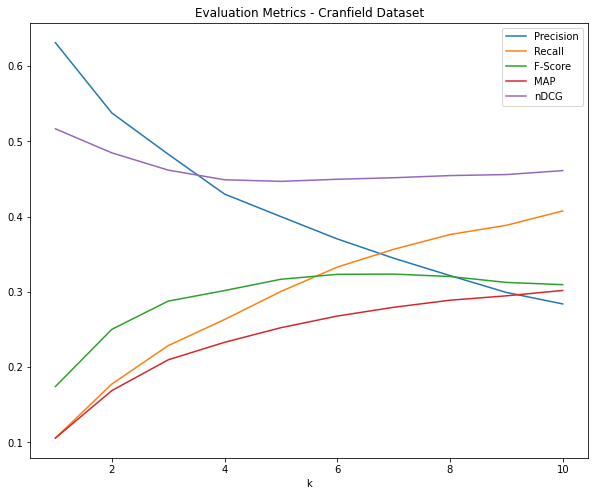

In [9]:
doc_IDs_ordered  = []

for j in tqdm(range(Q)):
  cos_sim = {}
  for doc_id, doc_vector in index_doc.items():
      cos_sim[doc_id] = cosine_similarity(doc_vector,TQ_matrix[:,j])
  doc_IDs_ordered.append([x for x, _ in sorted(cos_sim.items(),key = operator.itemgetter(1),reverse = True)])

results(doc_IDs_ordered)

# **EXPLICIT SEMANTIC ANALYSIS**

In [49]:
pip install wikipedia

In [50]:
%%time
import wikipedia
s1 = "https://petscan.wmflabs.org/?max_sitelink_count=&categories="
s2 = "&project=wikipedia&language=en&cb_labels_yes_l=1&edits%5Bflagged%5D=both&edits%5Bbots%5D=both&search_max_results=500&cb_labels_any_l=1&cb_labels_no_l=1&format=json&interface_language=en&edits%5Banons%5D=both&ns%5B0%5D=1&&doit="
words = ['Thermal_conduction','Aerodynamics','Aeroelasticity','Aerodynamic_heating','Flight_control_surfaces','Aircraft_engine_controls','Aeronautics',
'Aircraft_flight_control_system','Hypersonic_speed','Buckling','Slipstream','Propeller','Velocity','Orthotropic_material','Stress–strain_curve',
'Blended_wing_body','Flap_(aeronautics)','Hydrostatics','Aerodynamic_force','Airfoil','Pitot-static_system','Aileron','Viscosity']

wiki = []
for q in words:
    link = s1+q+s2
    petscan = requests.get(link).json()
    table = petscan['*'][0]['a']['*']
    topics = [item["title"].replace("_"," ") for item in table if item["title"].replace("_"," ") not in wiki]
    wiki += topics     
    
wiki_articles = {}
for w in wiki:
    try:
        wiki_articles[w] = wikipedia.page(w).content.lower()
    except:
        pass   

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


CPU times: user 10.6 s, sys: 687 ms, total: 11.3 s
Wall time: 3min 6s


In [51]:
processedWiki = preproc(wiki_articles)

In [55]:
def wiki_buildIndex(wiki_articles):
    wiki_types = []
    for article in wiki_articles.values():
        for w in article:
            if w not in wiki_types and w.isalpha():
                wiki_types.append(w)

    m = len(wiki_types)
    n = len(wiki_articles)
    TA_matrix = np.zeros([n,m])
    
    for row,article in enumerate(wiki_articles.values()):
      for word in article:
        if word.isalpha():
          col = wiki_types.index(word) 
          TA_matrix[row,col] += 1
        
    df = np.sum(TA_matrix > 0, axis=0)      
    idf = np.log(n/df)
    
    for i in range(m):
        TA_matrix[:,i] *= idf[i] 
    
    wiki_index = {word:vector for (word,vector) in zip(wiki_types,TA_matrix.transpose())}
    
    return wiki_types,wiki_index

In [56]:
%%time
wiki_types,wiki_index = wiki_buildIndex(processedWiki)

CPU times: user 31.6 s, sys: 68.8 ms, total: 31.7 s
Wall time: 31.7 s


Function for.....

In [57]:
def queryEx_ESA(queries,types,wiki_index,threshold,weigh):
        wr_dic = {}; expanded_query = {}
        for q_id,query in queries.items():
            sim_dic = {}; expanded = query.copy()
            for q in query:
                sim_dic[q] = 1;
                for t in types:
                  if t not in expanded:
                    # similarity propagation
                    try:
                      sim = cosine_similarity(wiki_index[q],wiki_index[t])
                      if sim >= threshold:
                        expanded.append(t)
                        sim_dic[t] = weigh
                          # else:
                          #     sim_dic[t] = max(sim,sim_dic[t])
                    except KeyError:
                      #f += 1
                      continue
            expanded_query[q_id] = expanded
            wr_dic[q_id] = sim_dic
        return expanded_query, wr_dic

In [58]:
%%time
threshold = 0.8
weigh = 0.1
exQ_ESA, wrD_ESA = queryEx_ESA(processedQueries,types_doc,wiki_index,threshold,weigh)

CPU times: user 2min 50s, sys: 515 ms, total: 2min 50s
Wall time: 2min 50s


In [59]:
TQ_matrix_esa = np.zeros([L,Q])
for col, query in exQ_ESA.items():                  # iterating over documents
    for word in query:
      try:
        row = types_doc.index(word)
        TQ_matrix_esa[row,col-1] += 1
      except:
        pass

for col in range(Q):
  weights = wrD_ESA[col+1]
  for q in exQ_ESA[col+1]:
    try:
      row = types_doc.index(q)    
      TQ_matrix_esa[row,col] = weights[q]*IDF[row]*TQ_matrix_esa[row,col]
    except:
      pass

Precision, Recall and F-score @ 1 : 0.64, 0.10732328309719502, 0.17677968571645725
MAP, nDCG @ 1 : 0.10732328309719502, 0.5255555555555556
Precision, Recall and F-score @ 2 : 0.5355555555555556, 0.17665290190660818, 0.24895244872124075
MAP, nDCG @ 2 : 0.16910632924600041, 0.48496515269749857
Precision, Recall and F-score @ 3 : 0.4844444444444445, 0.22918038204133373, 0.2885994356480713
MAP, nDCG @ 3 : 0.21055128445747184, 0.4634617932217854
Precision, Recall and F-score @ 4 : 0.4266666666666667, 0.2620207847758541, 0.2999634254819815
MAP, nDCG @ 4 : 0.23306118037128926, 0.44896554355350415
Precision, Recall and F-score @ 5 : 0.3982222222222222, 0.29980226028539986, 0.3154266347479878
MAP, nDCG @ 5 : 0.2531116778919622, 0.44821503755262915
Precision, Recall and F-score @ 6 : 0.36740740740740757, 0.3309920915269552, 0.32098875486191075
MAP, nDCG @ 6 : 0.2676596069743741, 0.4495367340460982
Precision, Recall and F-score @ 7 : 0.3415873015873019, 0.3548034612651781, 0.3211680299868845
MAP,

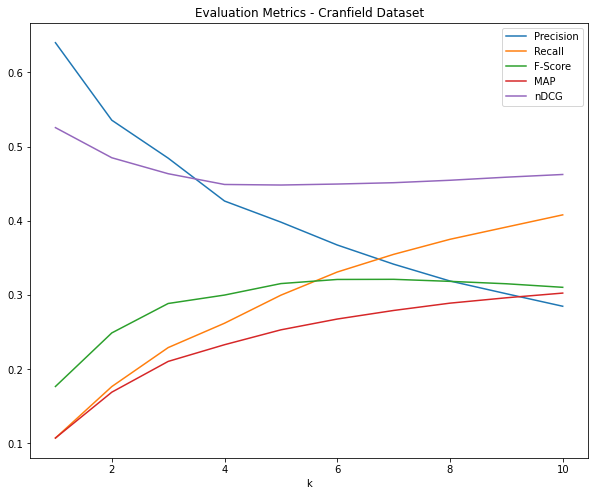

In [60]:
doc_IDs_ordered_esa  = []

for j in range(Q):
  cos_sim = {}
  for doc_id, doc_vector in index_doc.items():
      cos_sim[doc_id] = cosine_similarity(doc_vector,TQ_matrix_esa[:,j])
  doc_IDs_ordered_esa.append([x for x, _ in sorted(cos_sim.items(),key = operator.itemgetter(1),reverse = True)])

results(doc_IDs_ordered_esa)

## **IMPLEMENTATION OF LATENT SEMANTIC INDEXING ON CRANFIELD DATASET**

**Importing essentials**

In [19]:
import gensim
from gensim import corpora

**Using Gensim for CBoW implementation**

In [20]:
cd = corpora.Dictionary(processedDocs.values())
BoW_corpus = [cd.doc2bow(doc) for doc in processedDocs.values()]

Objects of the class ***gensim.models.TfidfModel*** realize the transformation between word-document co-occurrence matrix (int) into a locally/globally weighted TF-IDF matrix (positive floats).

In [21]:
tfidf = gensim.models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

***gensim.models.LsiModel*** implements fast truncated SVD (Singular Value Decomposition)
After searching over large number of values, parameter ***num_topics = 250*** was chosen to be the optimal choice.

In [22]:
lsi = gensim.models.LsiModel(corpus_tfidf, num_topics=250)
index = gensim.similarities.MatrixSimilarity(lsi[corpus_tfidf])

Representing queries in ***Latent Concept space*** followed by computing cosine similarity between documents.

In [23]:
new_vecQ = [cd.doc2bow(qry) for qry in processedQueries.values()]
vec_bow_tfidfQ = [tfidf[q] for q in new_vecQ]
vec_lsiQ = [lsi[i] for i in vec_bow_tfidfQ]
sims = [index[i] for i in vec_lsiQ]

Ranking the documents in the decreasing order of closeness to a query

In [24]:
doc_IDs_ordered_LSI = [[i+1 for i,_ in sorted(enumerate(s), key=lambda item: -item[1])] for s in sims]

Evaluating and displaying ***IR performance of LSI***

**Note:** Outputs differ with each run

Precision, Recall and F-score @ 1 : 0.6888888888888889, 0.11277958378156583, 0.1858203487571203
MAP, nDCG @ 1 : 0.11277958378156583, 0.5611111111111111
Precision, Recall and F-score @ 2 : 0.5844444444444444, 0.18847734243951103, 0.267332841557774
MAP, nDCG @ 2 : 0.18036747391297595, 0.5191213989891625
Precision, Recall and F-score @ 3 : 0.5392592592592592, 0.25534568710663885, 0.3221351082715978
MAP, nDCG @ 3 : 0.23318979198505743, 0.5053123411505555
Precision, Recall and F-score @ 4 : 0.48777777777777775, 0.3010203713081761, 0.3446270552435363
MAP, nDCG @ 4 : 0.264768851555521, 0.49707518502268494
Precision, Recall and F-score @ 5 : 0.44088888888888916, 0.33496355158468955, 0.35163227241940404
MAP, nDCG @ 5 : 0.2864950549817245, 0.4906749764976129
Precision, Recall and F-score @ 6 : 0.4059259259259261, 0.36878291378910927, 0.3569060989081701
MAP, nDCG @ 6 : 0.3054660429124826, 0.49233828878256264
Precision, Recall and F-score @ 7 : 0.37460317460317477, 0.389723942477197, 0.35264705229

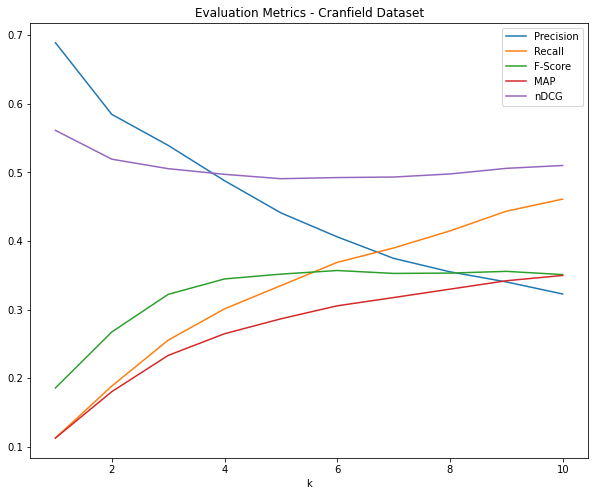

In [25]:
results(doc_IDs_ordered_LSI)

100%|██████████| 100/100 [09:47<00:00,  5.88s/it]
No handles with labels found to put in legend.


(192, 0.5156141736654976)


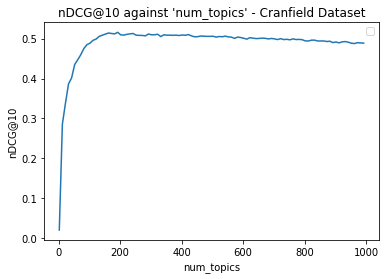

In [26]:
#will take some time to run as it is computing nDCG for multiple no of topics

def num_topics_selector(docs,queries):
  cd = corpora.Dictionary(docs)
  BoW_corpus = [cd.doc2bow(line) for line in docs]
  tfidf = gensim.models.TfidfModel(BoW_corpus)
  corpus_tfidf = tfidf[BoW_corpus]
  new_vecQ = [cd.doc2bow(qry) for qry in queries]
  vec_bow_tfidfQ = [tfidf[q] for q in new_vecQ]
  nDCG = {}
  for n in tqdm(range(2,1000,10)):
    lsi = gensim.models.LsiModel(corpus_tfidf, num_topics=n)
    index = gensim.similarities.MatrixSimilarity(lsi[corpus_tfidf])
    vec_lsiQ = [lsi[i] for i in vec_bow_tfidfQ]
    sims = [index[i] for i in vec_lsiQ]
    order = [[i+1 for i,_ in sorted(enumerate(s), key=lambda item: -item[1])] for s in sims]
    nDCG[n] = evaluator.meanNDCG(order, query_ids, qrels, 10)
  return nDCG

outputs = num_topics_selector(processedDocs.values(),processedQueries.values())
print((max(outputs,key = outputs.get),outputs[max(outputs,key = outputs.get)]))
plt.plot(list(outputs.keys()),list(outputs.values()))
plt.legend()
plt.title("nDCG@10 against 'num_topics' - Cranfield Dataset")
plt.xlabel("num_topics")
plt.ylabel("nDCG@10")
plt.savefig("LSA_selection.png")

# **Word2Vec**

Defining an iterator that yields preprocessed docs of Cranfield


In [27]:
import gensim.models

class MyCorpus:
  def __iter__(self):
      for doc in processedDocs.values():
        yield doc
sentences = MyCorpus()

Training Word2Vec ***Skip Gram Model*** with Cranfield

In [28]:
model = gensim.models.Word2Vec(sentences, min_count=1,size= 700,workers=4, window =3, sg =1);

Finding most similar terms of types in queries using ***model.wv.most_similar***

In [29]:
mostSim = {term:model.wv.most_similar(term)[:5] for term in types_qry if term in types_doc}

Query Expansion with ***mostSim*** and providing a small weight to the expanded queries with an intent to not spoil the nature of queries.

In [30]:
def queryEx_w2v(processedQueries,mostSim,weight):
  wr_dic = {}; expanded_query = {}
  for q_id,qry in processedQueries.items():
    sim_dic = {}; expanded = qry.copy();
    for q in qry:
      sim_dic[q] = 1
      try:
        for i in mostSim[q]:
          if i[0] not in expanded:
            expanded.append(i[0])
            #sim_dic[i[0]] = i[1] #watch out
            sim_dic[i[0]] = weight
      except KeyError:
        pass
    
    expanded_query[q_id] = expanded
    wr_dic[q_id] = sim_dic
  return expanded_query, wr_dic

In [31]:
exQ_w2v, wrD_w2v = queryEx_w2v(processedQueries,mostSim,0.1)

Computing Term Query Matrix for the expanded query

In [32]:
TQ_matrix_w2v = np.zeros([L,Q])
for col, query in exQ_w2v.items():                  # iterating over documents
    for word in query:
      try:
        row = types_doc.index(word)
        TQ_matrix_w2v[row,col-1] += 1
      except:
        pass

for col in range(Q):
  weights = wrD_w2v[col+1]
  for q in exQ_w2v[col+1]:
    try:
      row = types_doc.index(q)    
      TQ_matrix_w2v[row,col] = weights[q]*IDF[row]*TQ_matrix_w2v[row,col]
    except:
      pass

100%|██████████| 225/225 [00:51<00:00,  4.38it/s]


Precision, Recall and F-score @ 1 : 0.6133333333333333, 0.10232665010056201, 0.16846222539899694
MAP, nDCG @ 1 : 0.10232665010056201, 0.5033333333333333
Precision, Recall and F-score @ 2 : 0.54, 0.1788048320389305, 0.25198405091486564
MAP, nDCG @ 2 : 0.16822474967814632, 0.48036349651571514
Precision, Recall and F-score @ 3 : 0.48148148148148134, 0.2263744207549803, 0.28599189049666646
MAP, nDCG @ 3 : 0.20590686243069684, 0.45593629650872464
Precision, Recall and F-score @ 4 : 0.43666666666666665, 0.26643322854123913, 0.30616159768015383
MAP, nDCG @ 4 : 0.23205681690614152, 0.448491351396789
Precision, Recall and F-score @ 5 : 0.40622222222222243, 0.30286961885275837, 0.3204315548364994
MAP, nDCG @ 5 : 0.2515700959444979, 0.44845887922696753
Precision, Recall and F-score @ 6 : 0.3733333333333333, 0.33385934954127205, 0.32520585856693707
MAP, nDCG @ 6 : 0.2674867840214859, 0.4486097600239275
Precision, Recall and F-score @ 7 : 0.3434920634920639, 0.35811673413199, 0.3238223770783774
MAP

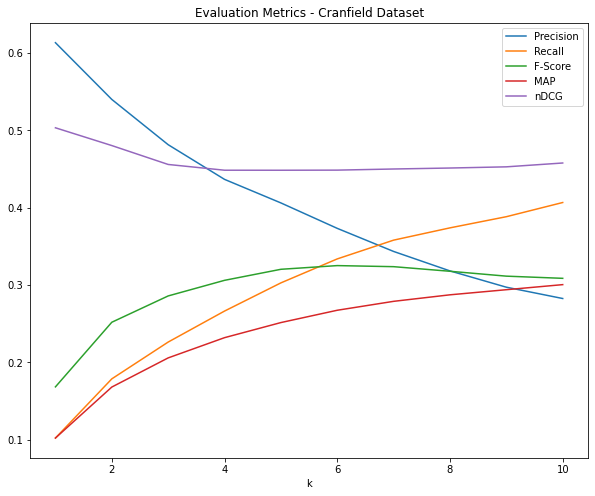

In [33]:
doc_IDs_ordered_w2v  = []

for j in tqdm(range(Q)):
  cos_sim = {}
  for doc_id, doc_vector in index_doc.items():
      cos_sim[doc_id] = cosine_similarity(doc_vector,TQ_matrix_w2v[:,j])
  doc_IDs_ordered_w2v.append([x for x, _ in sorted(cos_sim.items(),key = operator.itemgetter(1),reverse = True)])

results(doc_IDs_ordered_w2v)